In [1]:
import warnings
import numpy as np
import torch
from mapped_rnn import ClassicalMappedQRNN
from qubit_rnn import QRNN

batch_size = 10
sequence_length = 5
input_size = 1

warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_machine_learning")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="qiskit")

In [2]:
# Define ranges for Rx and Rz
rx_values = np.linspace(-np.pi, np.pi, 50)  # Example range for Rx
rz_values = np.linspace(-np.pi, np.pi, 50)  # Example range for Rz

rx_result = []
rz_result = []
qrnn_outputs = []

# Loop through Rx and Rz combinations
for rx in rx_values:
    for rz in rz_values:
        # Update QRNN parameters
        qrnn = QRNN(sequence_length=sequence_length, initial_params=(rx,rz))

        input_data = (20000 * torch.rand(batch_size, sequence_length, input_size, dtype=torch.float32)) - 10000

        # Get the QRNN output
        output = qrnn(input_data).detach().numpy()

        for i in range(batch_size):  # Loop through each sample in the batch
            qrnn_outputs.append(output[i][0])

            rx_result.append(rx)
            rz_result.append(rz)

# Convert to arrays for plotting
qrnn_outputs = np.array(qrnn_outputs)

In [3]:
# Define ranges for Rx and Rz
mapped_rx_values = np.linspace(-np.pi, np.pi, 50)  # Example range for Rx
mapped_rz_values = np.linspace(-np.pi, np.pi, 50)  # Example range for Rz

# Storage for results
mapped_rx_result = []
mapped_rz_result = []
mapped_qrnn_outputs = []

for rx in mapped_rx_values:
    for rz in mapped_rz_values:
        # Initialize model with custom Rx and Rz matrices
        model = ClassicalMappedQRNN(input_size=input_size, alpha=rx, beta=rz)

        # Generate input data
        input_data = (20000 * torch.rand(batch_size, sequence_length, input_size,
                                       dtype=torch.float32)) - 10000

        # Get model output
        output = model(input_data).detach().numpy()

        # Record results for each batch sample
        for i in range(batch_size):
            mapped_qrnn_outputs.append(output[i][0])

            mapped_rx_result.append(rx)
            mapped_rz_result.append(rz)

# Convert to arrays
mapped_qrnn_outputs = np.array(mapped_qrnn_outputs)

/home/cup/quantum computing/QRNN/QRNN/mapped_rnn.py:38: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  matrix = torch.tensor([


/tmp/ipykernel_42719/179781695.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax8.boxplot([qrnn_outputs, mapped_qrnn_outputs],


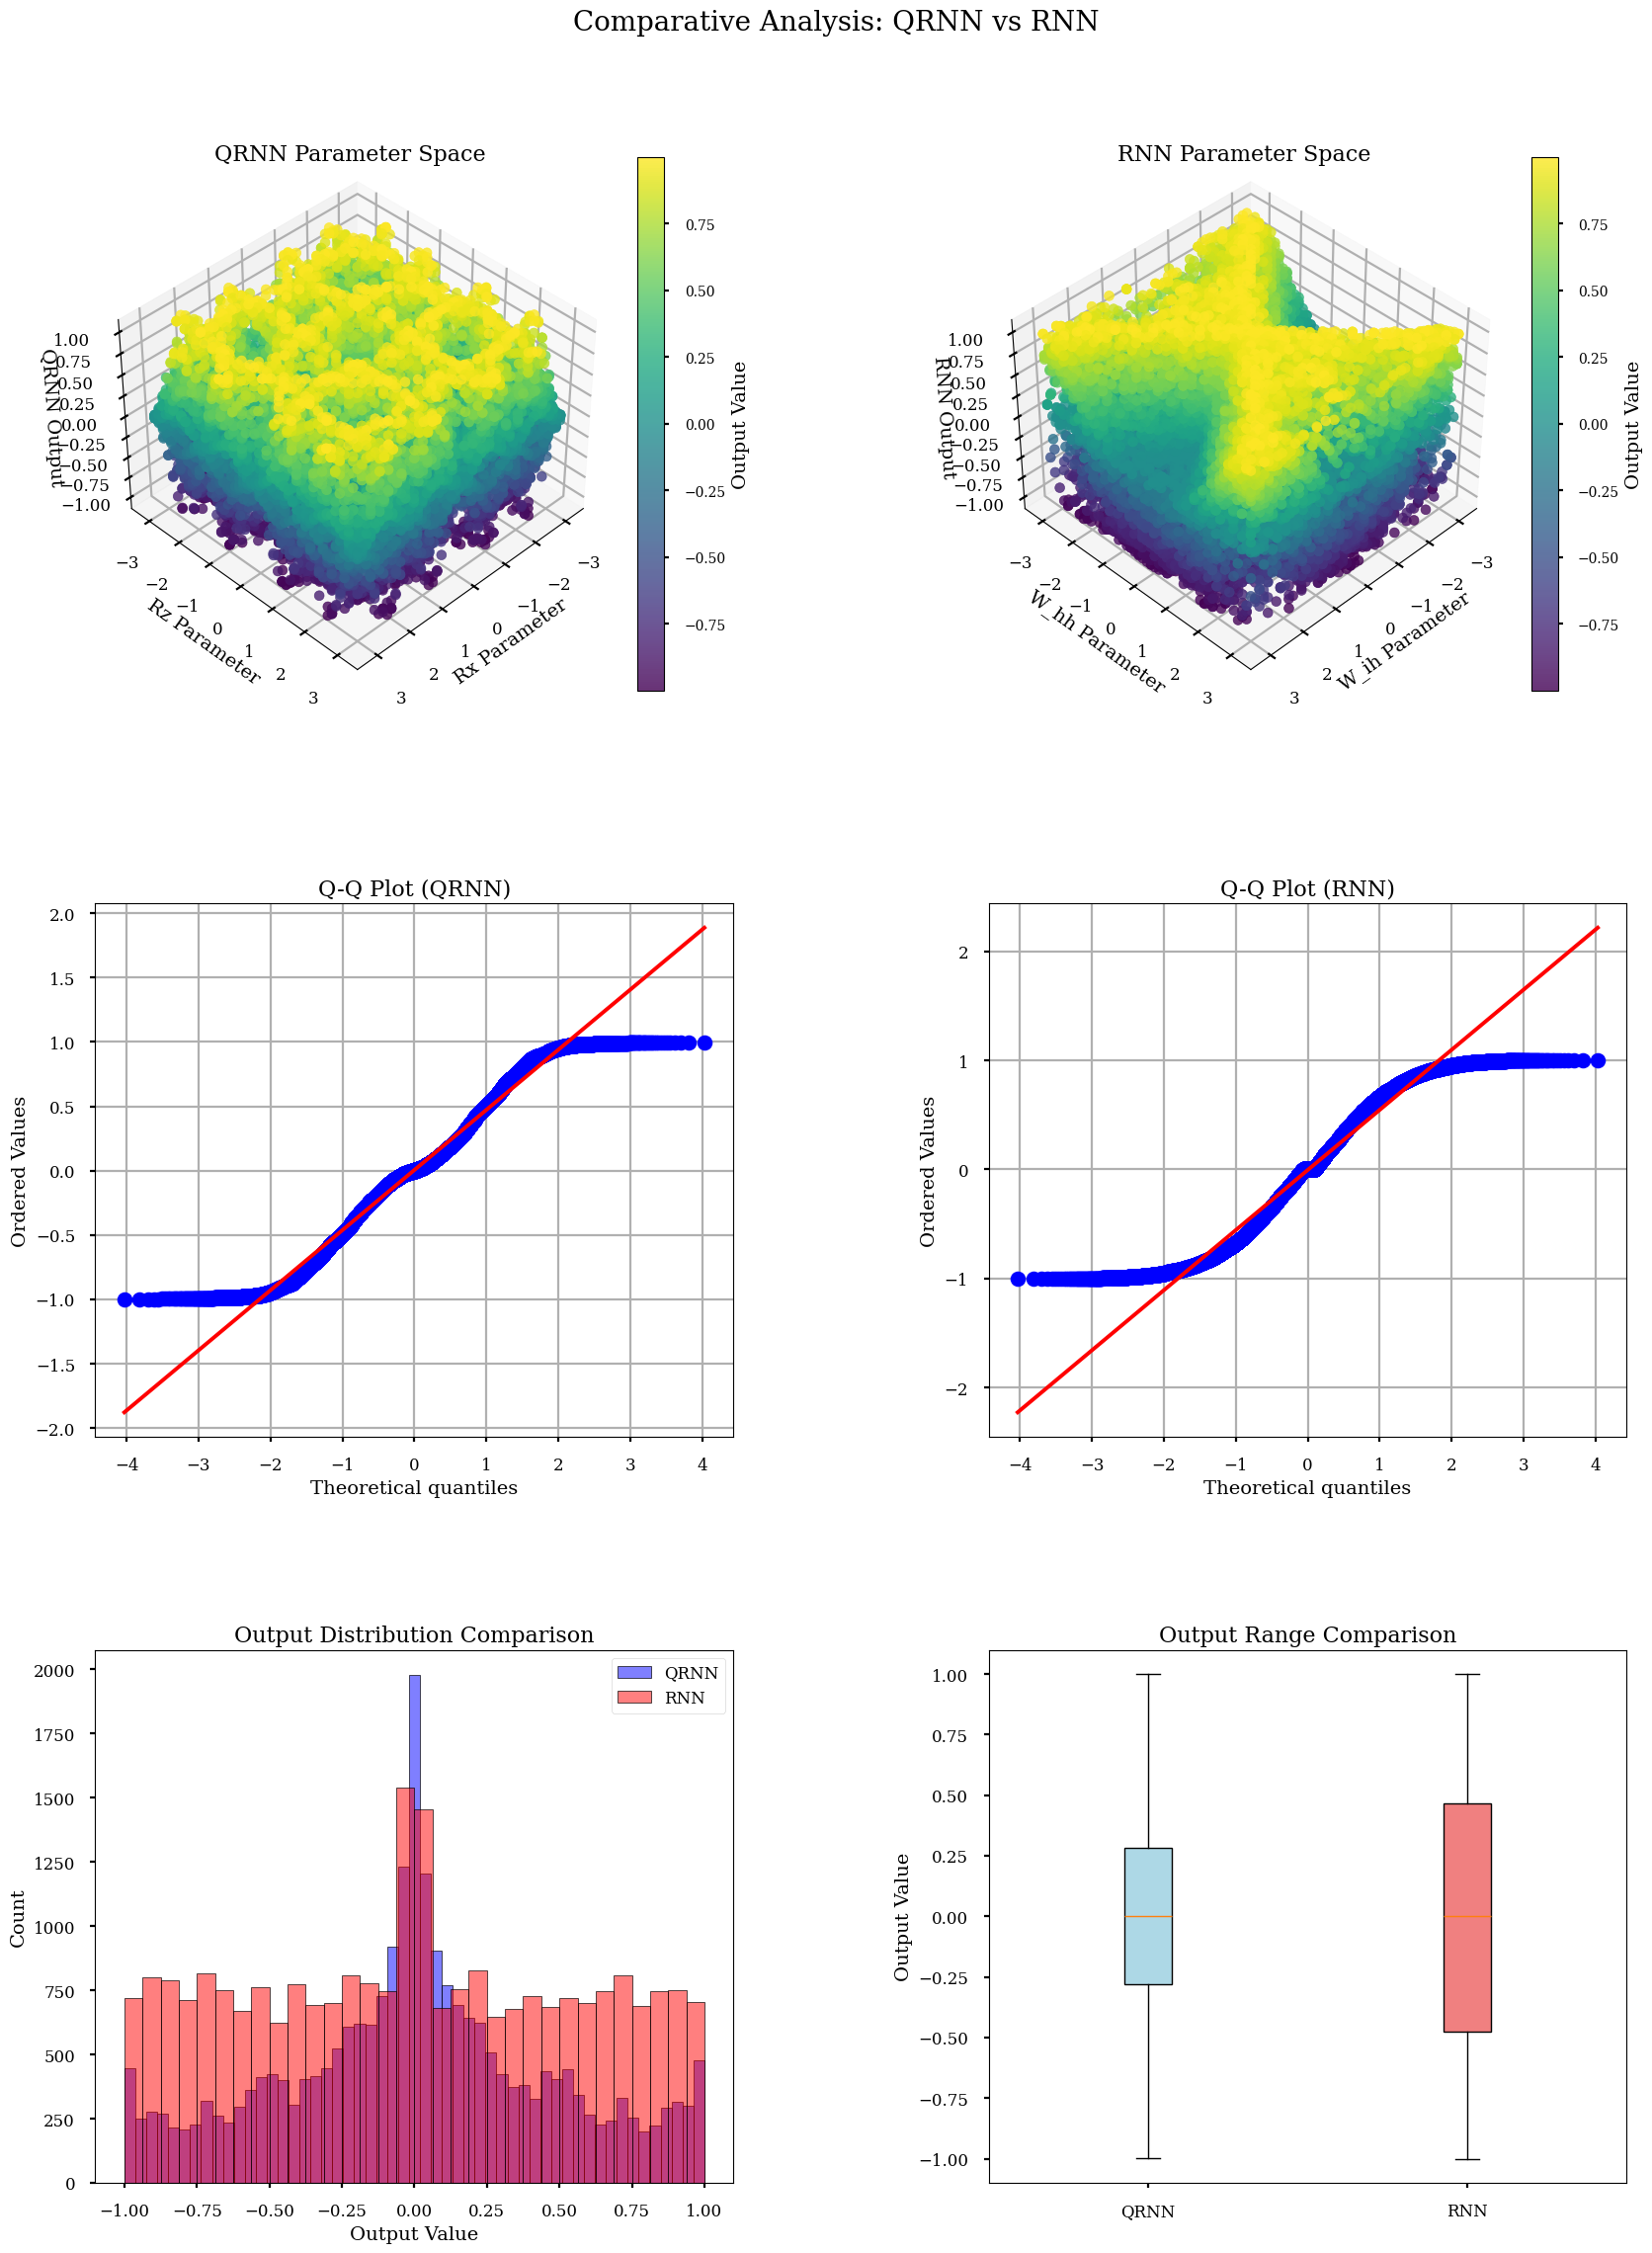

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# numpy array로 변환
rx_result = np.array(rx_result)
rz_result = np.array(rz_result)

mapped_rx_result = np.array(mapped_rx_result)
mapped_rz_result = np.array(mapped_rz_result)

# Set style for publication quality
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update({
   'font.family': 'serif',
   'font.size': 12,
   'axes.labelsize': 14,
   'axes.titlesize': 16,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'legend.fontsize': 12,
   'figure.figsize': (20, 25)  # height 늘림
})

# Create main figure with subplots
fig = plt.figure(figsize=(20, 25))

# 1. 3D Parameter Space Plots (Row 1)
# QRNN Plot
ax1 = fig.add_subplot(321, projection='3d')
scatter1 = ax1.scatter(rx_result, rz_result, qrnn_outputs,
                     c=qrnn_outputs, cmap='viridis', alpha=0.8,
                     s=50)
ax1.set_xlabel('Rx Parameter', labelpad=10)
ax1.set_ylabel('Rz Parameter', labelpad=10)
ax1.set_zlabel('QRNN Output', labelpad=10)
ax1.set_title('QRNN Parameter Space')
ax1.view_init(elev=40, azim=45)
cbar1 = plt.colorbar(scatter1, ax=ax1, label="Output Value")
cbar1.ax.tick_params(labelsize=10)

# RNN Plot
ax2 = fig.add_subplot(322, projection='3d')
scatter2 = ax2.scatter(mapped_rx_result, mapped_rz_result, mapped_qrnn_outputs,
                     c=mapped_qrnn_outputs, cmap='viridis', alpha=0.8,
                     s=50)
ax2.set_xlabel('W_ih Parameter', labelpad=10)
ax2.set_ylabel('W_hh Parameter', labelpad=10)
ax2.set_zlabel('RNN Output', labelpad=10)
ax2.set_title('RNN Parameter Space')
ax2.view_init(elev=40, azim=45)
cbar2 = plt.colorbar(scatter2, ax=ax2, label="Output Value")
cbar2.ax.tick_params(labelsize=10)

# 2. Q-Q plots
ax5 = fig.add_subplot(323)
stats.probplot(qrnn_outputs, dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot (QRNN)')
ax5.grid(visible=True)

ax6 = fig.add_subplot(324)
stats.probplot(mapped_qrnn_outputs, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot (RNN)')
ax6.grid(visible=True)

# 3. Distribution plots
ax7 = fig.add_subplot(325)
sns.histplot(data=qrnn_outputs, label='QRNN', alpha=0.5, ax=ax7, color='blue')
sns.histplot(data=mapped_qrnn_outputs, label='RNN', alpha=0.5, ax=ax7, color='red')
ax7.set_title('Output Distribution Comparison')
ax7.legend()
ax7.set_xlabel('Output Value')
ax7.set_ylabel('Count')

ax8 = fig.add_subplot(326)
bplot = ax8.boxplot([qrnn_outputs, mapped_qrnn_outputs],
                   labels=['QRNN', 'RNN'],
                   patch_artist=True)
ax8.set_title('Output Range Comparison')
ax8.set_ylabel('Output Value')

# Color boxes
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bplot['boxes'], colors):
   patch.set_facecolor(color)

# Add overall title and adjust layout
plt.suptitle('Comparative Analysis: QRNN vs RNN', y=0.98, fontsize=20)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.92, bottom=0.1)  # hspace & wspace 조정하여 겹침 방지

plt.show()
